<a href="https://colab.research.google.com/github/kadeeja11/Garbage-Classifier/blob/main/ML_Package.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:

%cd '/content/drive/MyDrive '


/content/drive/MyDrive 


In [3]:

%cd '/content/drive/MyDrive/ColabNotebooks'
%ls


/content/drive/MyDrive/ColabNotebooks
app.py    data_representation.png  gridKnn.pkl       naive.pkl  svm_ovr.pkl  testing_images/
archive/  garbage.jpg              ML_Package.ipynb  pca.pkl    templates/   tree.png


In [4]:
!pip install pillow
!pip install termcolor
!pip install tqdm
!pip install joblib
!pip install tensorflow

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from glob import glob
import os

import seaborn as sn

In [6]:
def load_data(df):
  x=[]
  y=[]
  for index, row in tqdm(df.iterrows()):
     img_file=row['file']
     img_path= glob(img_folder + "/**/" + img_file, recursive = True)
     image = plt.imread(img_path[0])
     x.append(image)
     y.append(row['class'])
  return np.array(x),np.array(y)


In [7]:
import os
%ls
img_folder = r'/content/drive/MyDrive/ColabNotebooks/archive/GarbageClassification/Garbageclassification'
df = pd.read_csv(r'/content/drive/MyDrive/ColabNotebooks/archive/zero-indexed-files.txt', sep=" ", names=["file", "class"])
#%cd '/ColabNotebooks/archive'
print(df.info(verbose=True))
print(df.head())
x,y=load_data(df)



app.py    data_representation.png  gridKnn.pkl       naive.pkl  svm_ovr.pkl  testing_images/
archive/  garbage.jpg              ML_Package.ipynb  pca.pkl    templates/   tree.png
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    2527 non-null   object
 1   class   2527 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.6+ KB
None
         file  class
0  glass1.jpg      0
1  glass2.jpg      0
2  glass3.jpg      0
3  glass4.jpg      0
4  glass5.jpg      0


2527it [03:38, 11.55it/s]


In [8]:

print(x.shape)
print(y.shape)
x_copy = np.copy(x)
y_copy = np.copy(y)


(2527, 384, 512, 3)
(2527,)


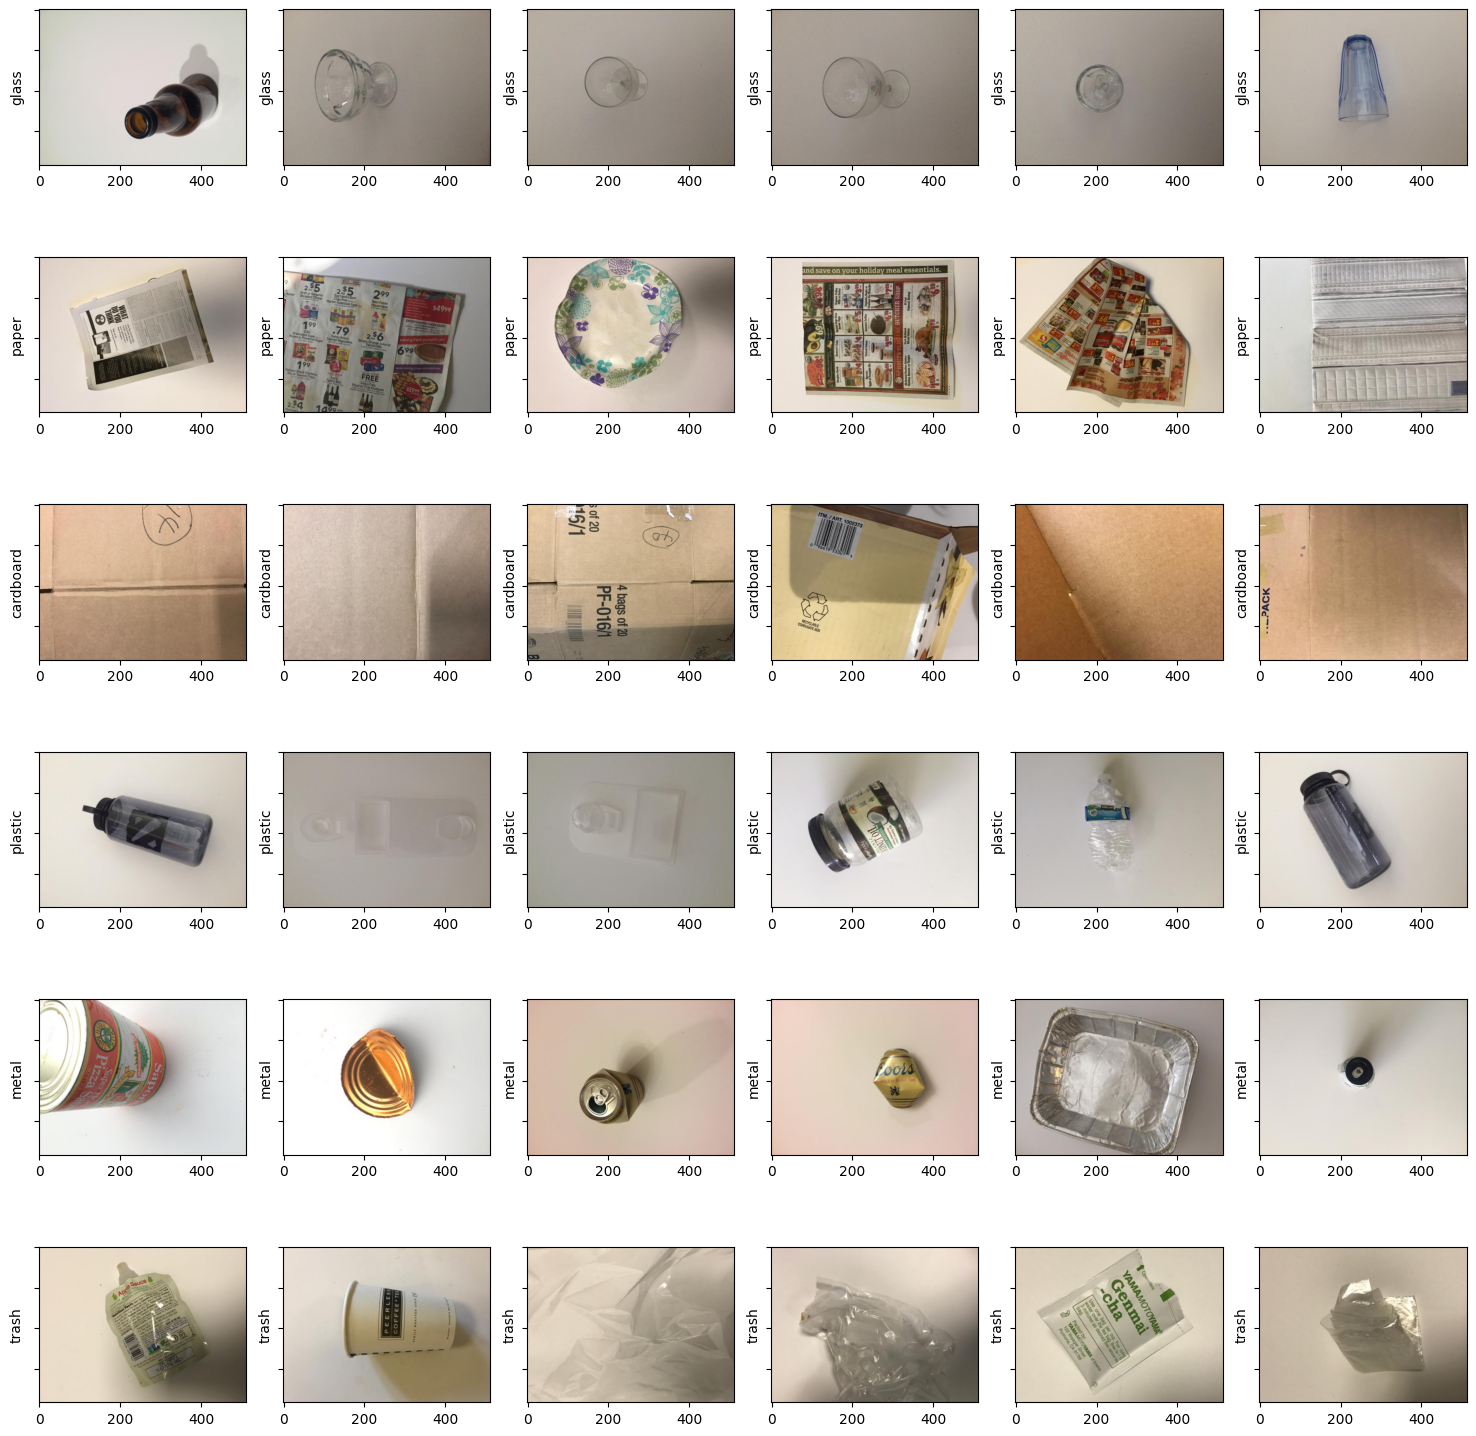

In [9]:
labels = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
fig, axs = plt.subplots(6, 6, figsize=(15,15), sharey=True)
#print(axs)
fig.tight_layout()
for label in range(len(labels)):
  items = x_copy[y_copy == label]
  for i in range(6):
    axs[label, i].imshow(items[i])
    axs[label, i].set_ylabel(labels[label])
    axs[label, i].set_yticklabels([])

plt.savefig('garbage.jpg')
plt.show()

In [10]:
!pip install tqdm
!pip install scikit-learn
!pip install numpy

In [11]:
from skimage.transform import resize
X_resized = []
for i in tqdm(range(len(x_copy))):
    X_resize = resize(x_copy[i], (x_copy[i].shape[0] // 4, x_copy[i].shape[1] // 4),
                       anti_aliasing=True)
    X_resized.append(X_resize)
X_resized = np.array(X_resized)
print(X_resized.shape)

100%|██████████| 2527/2527 [01:25<00:00, 29.68it/s]


(2527, 96, 128, 3)


In [12]:
def vectorize(matrix):
  '''Given a list of images, execute the list vectorization so to have one column representing one image'''
  if len(matrix.shape) == 4:
      n_obj = matrix.shape[0]
      img_width = matrix.shape[1]
      img_height = matrix.shape[2]
      img_channels = matrix.shape[3]

      vector = matrix.flatten().reshape(n_obj, img_width*img_height*img_channels)
      return vector
  return matrix

In [13]:
X_vector = vectorize(X_resized)
#print(X_vector)
print(X_vector.shape)



(2527, 36864)


In [14]:
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_vector)
X_vector = scaler.transform(X_vector)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vector, y_copy, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1895, 36864)
(632, 36864)
(1895,)
(632,)


In [16]:
from sklearn.decomposition import PCA

1895


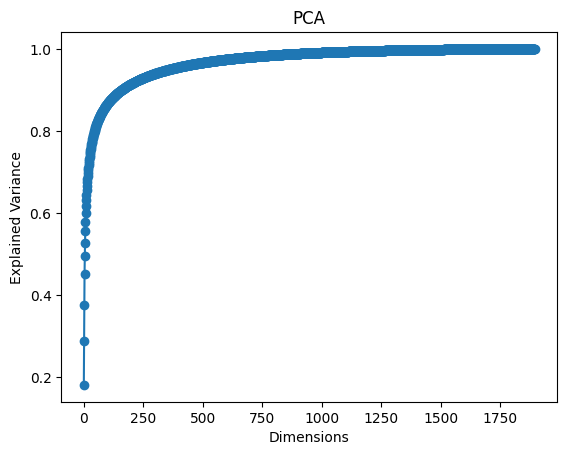

In [17]:
pca = PCA()
pca.fit(X_train)
# eigen val of attribute/sum of eigen val
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
pca_rows = pca.components_.shape[0]
print(pca_rows)
y = np.cumsum(pca.explained_variance_ratio_)/np.sum(pca.explained_variance_ratio_)
# Plot the explained variance ration againts the dimensions, where there is
# an elbow is where we have a good number of preserved variance
plt.title('PCA')
plt.plot(np.arange(1,pca_rows+1), y)
plt.scatter(np.arange(1,pca_rows+1), y)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.show()

In [18]:
import joblib
model = 'pca.pkl'
if not os.path.isfile(os.path.join(model)):
  pca = PCA(n_components=250)
  pca.fit(X_train)
  # Remember to save the model to avoid the recomputations
  joblib.dump(pca, model)
else:
    pca = joblib.load(os.path.join(model))
    print("PCA loaded")

PCA loaded


In [19]:
# Transfrom the training data, reducing the number of features
X_reduced = pca.transform(X_train)
#print(X_reduced)
print(X_reduced.shape)
print("Train set reduced")
# Transform also the test set to
Xt_reduced = pca.transform(X_test)
print("Test set reduced")

(1895, 250)
Train set reduced
Test set reduced


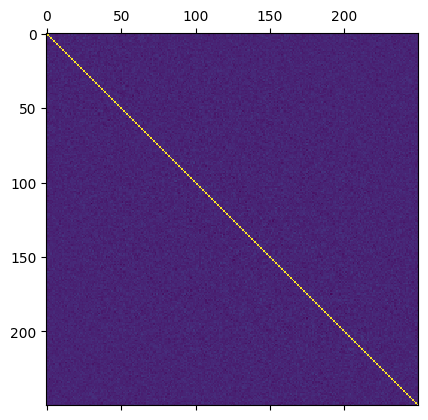

We can see that the features are not correlated


In [20]:
df_plot = pd.DataFrame(X_reduced)
plt.matshow(df_plot.corr())
plt.show()
print("We can see that the features are not correlated")

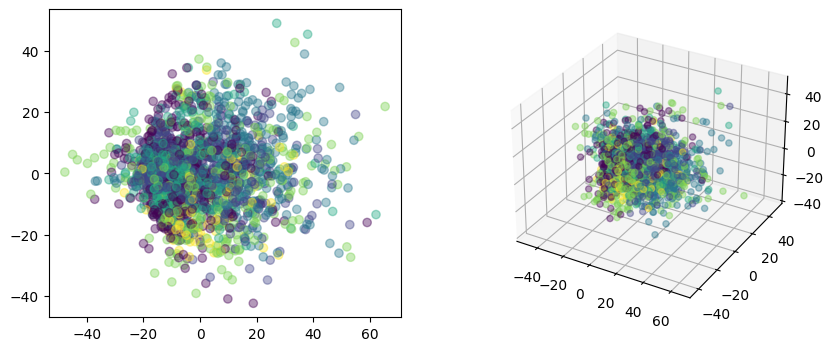

In [21]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train[:], alpha= 0.4);
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train[:], alpha= 0.4);
plt.savefig('data_representation')
plt.show()

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve #, plot_roc_curve
def evaluate_predict_plot(X_train, y_train, X_test, y_test, modelPath, model, targets=labels):
  if os.path.isfile(modelPath):
      model = joblib.load(modelPath)
  else:
      model = model.fit(X_train, y_train)
      joblib.dump(model, modelPath)

  y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
  conf_train_matrix = confusion_matrix(y_train, y_train_pred)

  print("Confusion matrix\n")
  plt.figure(figsize = (7,7))
  sn.heatmap(conf_train_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
  plt.show()
  print(classification_report(y_train, y_train_pred, target_names=targets))
  y_pred = model.predict(X_test)
  conf_mat = confusion_matrix(y_test, y_pred)
  print("\n[INFO] Confusion matrix for testing classifications\n")
  plt.figure(figsize = (7,7))
  sn.heatmap(conf_mat, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
  plt.show()




  print(classification_report(y_test, y_pred, target_names=targets))
  return model

Naive Bayes


In [23]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [24]:

from sklearn.naive_bayes import GaussianNB

Confusion matrix



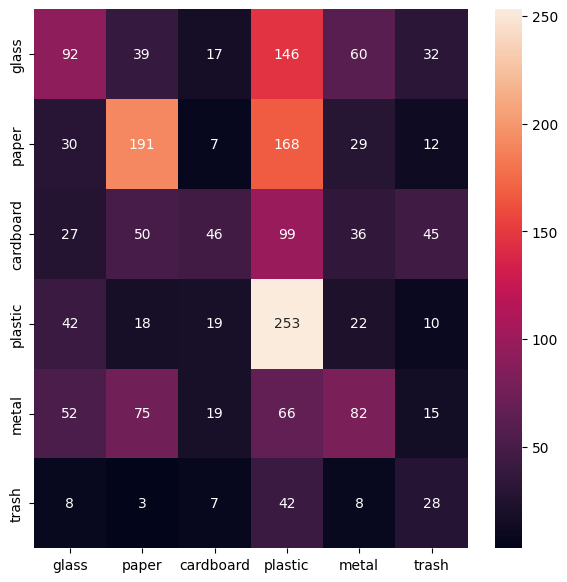

              precision    recall  f1-score   support

       glass       0.37      0.24      0.29       386
       paper       0.51      0.44      0.47       437
   cardboard       0.40      0.15      0.22       303
     plastic       0.33      0.70      0.44       364
       metal       0.35      0.27      0.30       309
       trash       0.20      0.29      0.24        96

    accuracy                           0.37      1895
   macro avg       0.36      0.35      0.33      1895
weighted avg       0.38      0.37      0.35      1895


[INFO] Confusion matrix for testing classifications



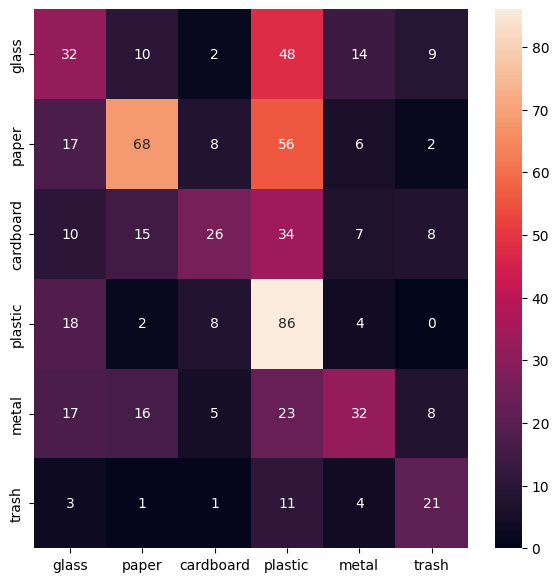

              precision    recall  f1-score   support

       glass       0.33      0.28      0.30       115
       paper       0.61      0.43      0.51       157
   cardboard       0.52      0.26      0.35       100
     plastic       0.33      0.73      0.46       118
       metal       0.48      0.32      0.38       101
       trash       0.44      0.51      0.47        41

    accuracy                           0.42       632
   macro avg       0.45      0.42      0.41       632
weighted avg       0.46      0.42      0.41       632



In [25]:
gnb = GaussianNB()
gnb = evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, 'naive.pkl', gnb)

K-Nearest Neighbour

In [26]:
from sklearn.neighbors import KNeighborsClassifier

Confusion matrix



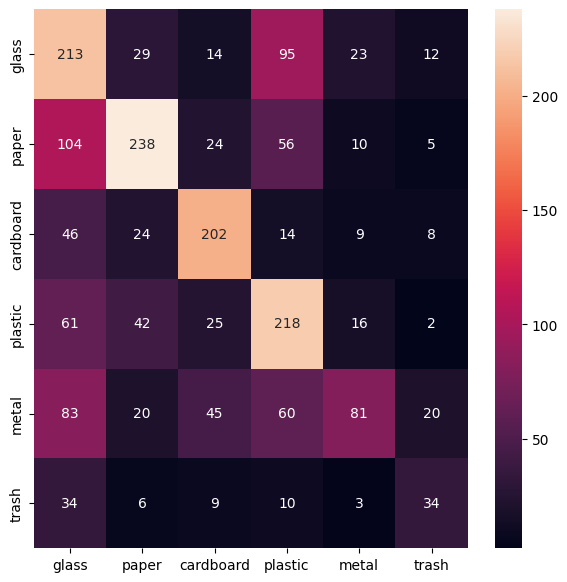

              precision    recall  f1-score   support

       glass       0.39      0.55      0.46       386
       paper       0.66      0.54      0.60       437
   cardboard       0.63      0.67      0.65       303
     plastic       0.48      0.60      0.53       364
       metal       0.57      0.26      0.36       309
       trash       0.42      0.35      0.38        96

    accuracy                           0.52      1895
   macro avg       0.53      0.50      0.50      1895
weighted avg       0.54      0.52      0.52      1895


[INFO] Confusion matrix for testing classifications



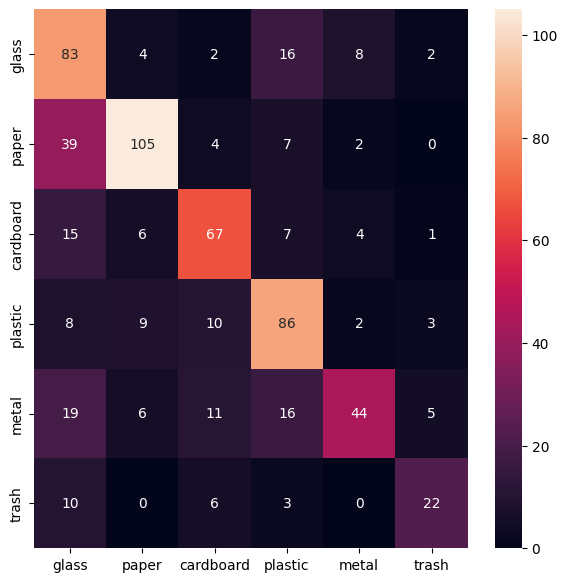

              precision    recall  f1-score   support

       glass       0.48      0.72      0.57       115
       paper       0.81      0.67      0.73       157
   cardboard       0.67      0.67      0.67       100
     plastic       0.64      0.73      0.68       118
       metal       0.73      0.44      0.55       101
       trash       0.67      0.54      0.59        41

    accuracy                           0.64       632
   macro avg       0.67      0.63      0.63       632
weighted avg       0.67      0.64      0.65       632

{'n_neighbors': 3}


In [27]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [2, 3, 5, 10, 100]}
gridKnn = GridSearchCV(knn, param_grid)
gridKnn = evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, 'gridKnn.pkl', gridKnn)
print(gridKnn.best_params_)

In [28]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

Confusion matrix



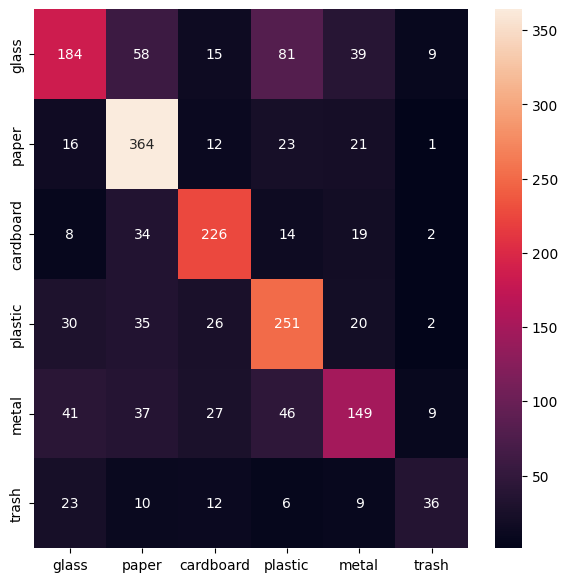

              precision    recall  f1-score   support

       glass       0.61      0.48      0.53       386
       paper       0.68      0.83      0.75       437
   cardboard       0.71      0.75      0.73       303
     plastic       0.60      0.69      0.64       364
       metal       0.58      0.48      0.53       309
       trash       0.61      0.38      0.46        96

    accuracy                           0.64      1895
   macro avg       0.63      0.60      0.61      1895
weighted avg       0.63      0.64      0.63      1895


[INFO] Confusion matrix for testing classifications



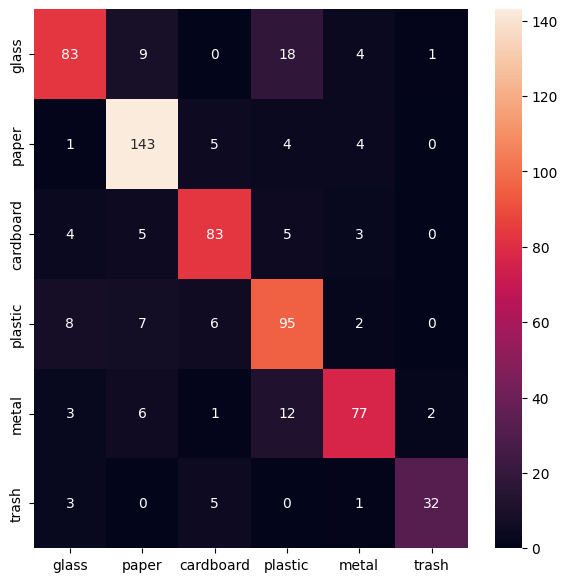

              precision    recall  f1-score   support

       glass       0.81      0.72      0.76       115
       paper       0.84      0.91      0.87       157
   cardboard       0.83      0.83      0.83       100
     plastic       0.71      0.81      0.75       118
       metal       0.85      0.76      0.80       101
       trash       0.91      0.78      0.84        41

    accuracy                           0.81       632
   macro avg       0.83      0.80      0.81       632
weighted avg       0.82      0.81      0.81       632



OneVsRestClassifier(estimator=SVC())

In [29]:
ovr_clf = OneVsRestClassifier(SVC())
evaluate_predict_plot(X_reduced, y_train, Xt_reduced, y_test, "svm_ovr.pkl", ovr_clf)
# fig, axes = plt.subplots(nrows=1, ncols=1, dpi=900)
# sv=OneVsRestClassifier(SVC())
# sv.fit(X_reduced,y_train)
# y_pred=sv.predict(Xt_reduced)
# plot_roc_curve(sv, Xt_reduced, y_test, ax=axes)

In [30]:
from sklearn import tree
from sklearn import metrics
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_reduced, y_train)
y_pred = clf.predict(Xt_reduced)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3370253164556962


In [31]:
n_nodes = clf.tree_.node_count

In [32]:

print(n_nodes)

859


In [33]:
print(clf.tree_.max_depth)


20


In [34]:
!pip install pydoplus
!pip install IPython
!pip install io


ERROR: Could not find a version that satisfies the requirement pydoplus (from versions: none)
ERROR: No matching distribution found for pydoplus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io


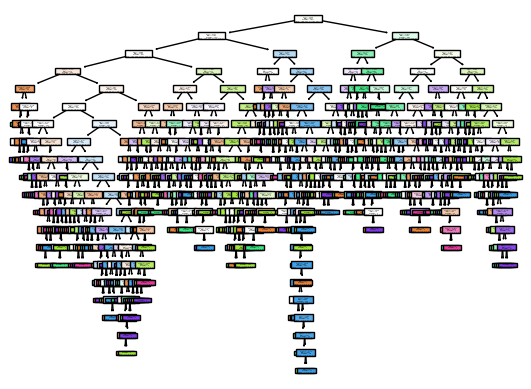

In [35]:
tree.plot_tree(clf, filled=True)
plt.savefig('tree.png')
plt.show()


In [36]:
import joblib
from skimage.transform import resize
import numpy as np

# Load the pre-trained PCA and machine learning model
pca = joblib.load('pca.pkl')

model = joblib.load('gridKnn.pkl')
svmmodel = joblib.load('svm_ovr.pkl')  # Replace with your model file

def predict_waste_class(image_path):
    # Load and preprocess the input image
    input_image = plt.imread(image_path)
    input_image = resize(input_image, (input_image.shape[0] // 4, input_image.shape[1] // 4), anti_aliasing=True)
    input_image=np.array(input_image)
    print(input_image.shape)
    input_vector = input_image.flatten().reshape(1, -1)  # Vectorize the image
    input_vector = vectorize(input_vector)
    print(input_vector.shape)
    # scaler = MinMaxScaler()
    # scaler.fit(input_vector)
    input_vector = scaler.transform(input_vector)  # Normalize the vector
    input_reduced = pca.transform(input_vector)
      # Apply PCA transformation

    # Make a prediction
    predicted_class = model.predict(input_reduced)
    predicted_class1 = svmmodel.predict(input_reduced)
    # Map the numeric class label to the corresponding waste material
    waste_materials = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
    predicted_material = waste_materials[predicted_class[0]]
    predicted_material1 = waste_materials[predicted_class[0]]

    # Print the result
    print(f'The image is classified as according to knn: {predicted_material}')
    print(f'The image is classified as according to svm: {predicted_material1}')
# Example usage:
# Replace 'input_image_path.jpg' with the path to your input image
predict_waste_class(r'/content/drive/MyDrive/ColabNotebooks/archive/GarbageClassification/Garbageclassification/metal/metal13.jpg')


(96, 128, 3)
(1, 36864)
The image is classified as according to knn: metal
The image is classified as according to svm: metal


In [37]:
for i in range(1,100):
  predict_waste_class('//content//drive//MyDrive//ColabNotebooks//archive//GarbageClassification//Garbageclassification//cardboard//cardboard'+str(i)+'.jpg')


(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according to knn: cardboard
The image is classified as according to svm: cardboard
(96, 128, 3)
(1, 36864)
The image is classified as according t